In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
articles = pd.read_json('my_guardian_articles.json')
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   object
 1   type                2000 non-null   object
 2   sectionId           2000 non-null   object
 3   sectionName         2000 non-null   object
 4   webPublicationDate  2000 non-null   object
 5   webTitle            2000 non-null   object
 6   webUrl              2000 non-null   object
 7   apiUrl              2000 non-null   object
 8   fields              2000 non-null   object
 9   tags                2000 non-null   object
 10  isHosted            2000 non-null   bool  
 11  pillarId            1980 non-null   object
 12  pillarName          1980 non-null   object
dtypes: bool(1), object(12)
memory usage: 205.1+ KB


## Prepping the Data

In [3]:
articles.head()


,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,tags,isHosted,pillarId,pillarName
0,technology/2023/oct/31/educators-teachers-ai-l...,article,technology,Technology,2023-10-31T10:00:39Z,‘Is this an appropriate use of AI or not?’: te...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Johana Bhuiyan', 'body': '<p>In <a...","[{'id': 'technology/technology', 'type': 'keyw...",False,pillar/news,News
1,technology/ng-interactive/2023/oct/25/a-day-in...,interactive,technology,Technology,2023-10-25T13:38:11Z,A day in the life of AI,https://www.theguardian.com/technology/ng-inte...,https://content.guardianapis.com/technology/ng...,{'byline': 'Hannah Devlin Science Corresponden...,"[{'id': 'technology/artificialintelligenceai',...",False,pillar/news,News
2,technology/2023/oct/24/alphabet-q3-earnings-go...,article,technology,Technology,2023-10-24T22:07:37Z,Google Cloud revenue misses expectations despi...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Kari Paul', 'body': '<p>Google is ...","[{'id': 'technology/alphabet', 'type': 'keywor...",False,pillar/news,News
3,stage/2023/sep/19/anthropology-review-hampstea...,article,stage,Stage,2023-09-19T12:02:55Z,Anthropology review – clever AI missing-person...,https://www.theguardian.com/stage/2023/sep/19/...,https://content.guardianapis.com/stage/2023/se...,"{'byline': 'Mark Lawson', 'body': '<p>While sc...","[{'id': 'stage/stage', 'type': 'keyword', 'sec...",False,pillar/arts,Arts
4,film/2023/aug/20/tim-review-clunky-ai-paranoia...,article,film,Film,2023-08-20T10:30:44Z,TIM review – clunky AI paranoia thriller,https://www.theguardian.com/film/2023/aug/20/t...,https://content.guardianapis.com/film/2023/aug...,"{'byline': 'Wendy Ide', 'body': '<p>This styli...","[{'id': 'film/thriller', 'type': 'keyword', 's...",False,pillar/arts,Arts


In [4]:
articles_field_data = pd.json_normalize(articles['fields'])

In [5]:
articles = articles.merge(articles_field_data, left_index=True, right_index=True)


In [6]:
articles['wordcount'] = pd.to_numeric(articles['wordcount'])

In [7]:
articles['webPublicationDate'] = pd.to_datetime(articles['webPublicationDate'])

## Data Counts over time

In [8]:
articles['webPublicationDate'].describe()

<ipython-input-8-a6523f342fc1>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  articles['webPublicationDate'].describe()


count                          2000
unique                         1974
top       2023-03-26 09:00:14+00:00
freq                              3
first     2020-08-21 14:20:31+00:00
last      2023-11-08 15:05:42+00:00
Name: webPublicationDate, dtype: object

In [9]:
time_grouper = pd.Grouper(key='webPublicationDate', freq='M')
count_over_time = articles.groupby(time_grouper).count().reset_index()[['webPublicationDate','id']]
count_over_time.head()

,webPublicationDate,id
0,2020-08-31 00:00:00+00:00,1
1,2020-09-30 00:00:00+00:00,0
2,2020-10-31 00:00:00+00:00,0
3,2020-11-30 00:00:00+00:00,2
4,2020-12-31 00:00:00+00:00,7


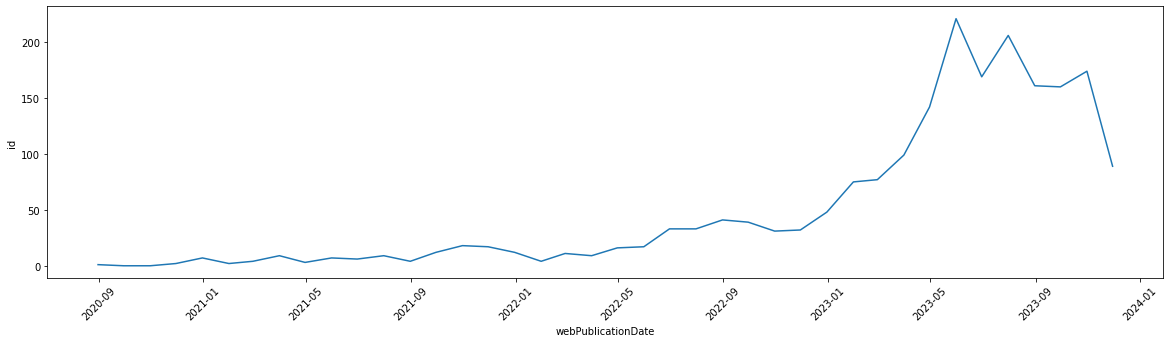

In [10]:
plt.figure(figsize=(20,5))
plot = sns.lineplot(data=count_over_time, x='webPublicationDate', y='id')

plot.tick_params(axis='x', labelrotation=45)

## Optional: Filtering by a Date Range

In [11]:
date_filter = articles['webPublicationDate'] >= 'January 2022'
articles = articles[date_filter]

In [12]:
articles['webPublicationDate'].describe()

<ipython-input-12-a6523f342fc1>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  articles['webPublicationDate'].describe()


count                          1887
unique                         1863
top       2023-03-26 09:00:14+00:00
freq                              3
first     2022-01-09 09:00:17+00:00
last      2023-11-08 15:05:42+00:00
Name: webPublicationDate, dtype: object

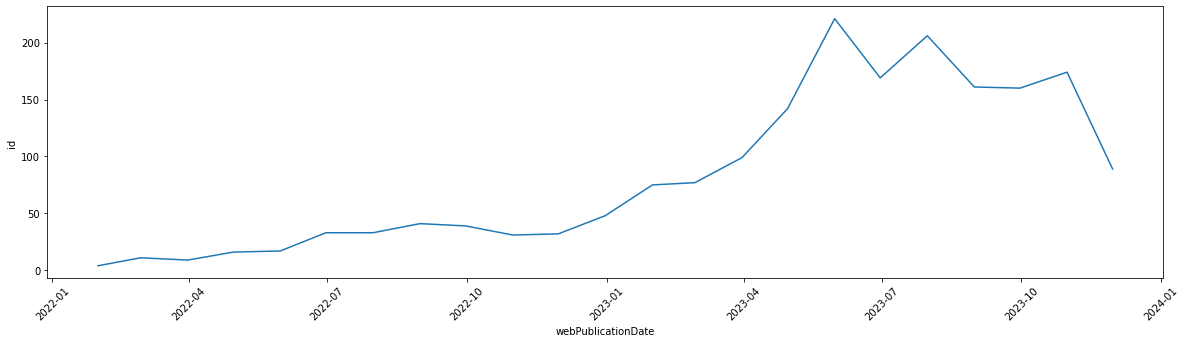

In [13]:
time_grouper = pd.Grouper(key='webPublicationDate', freq='M')
count_over_time = articles.groupby(time_grouper).count().reset_index()
plt.figure(figsize=(20,5))

plot = sns.lineplot(data=count_over_time, x='webPublicationDate', y='id')
plot.tick_params(axis='x', labelrotation=45)

## Appropriate Pillars?

In [14]:
pillar_counts = articles['pillarName'].value_counts()
pillar_counts


News         1072
Arts          479
Opinion       201
Lifestyle      73
Sport          42
Name: pillarName, dtype: int64

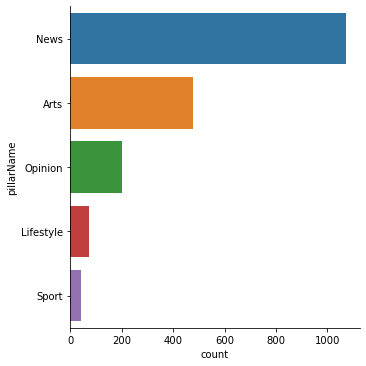

In [15]:
sns.catplot(data=articles, y='pillarName', kind='count', order=pillar_counts.index)

## Optional: Filtering by Pillar

In [16]:
chosen_pillars = ['News', 'Opinion']
pillar_filter = articles['pillarName'].isin(chosen_pillars)
articles = articles[pillar_filter]

In [17]:
new_pillar_counts = articles['pillarName'].value_counts()
new_pillar_counts

News       1072
Opinion     201
Name: pillarName, dtype: int64

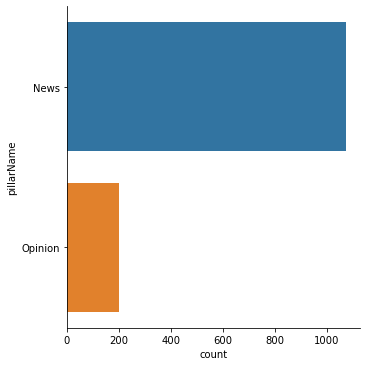

In [18]:
sns.catplot(data=articles, y='pillarName', kind='count', order=new_pillar_counts.index)

## Sections

In [143]:
section_counts = articles['sectionName'].value_counts()
section_counts

Technology            437
Opinion               201
Australia news        111
Business               95
World news             93
Politics               69
US news                66
Science                37
Environment            33
News                   31
Society                30
UK news                21
Media                  20
Global development     12
Education               5
From the Observer       5
Info                    4
Law                     2
Help                    1
Name: sectionName, dtype: int64

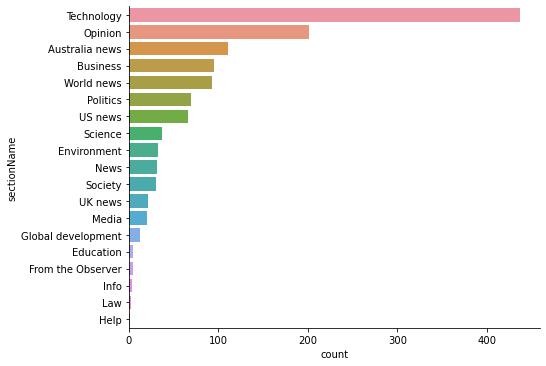

In [27]:

sns.catplot(data=articles, y='sectionName', kind='count', aspect=1.5, order=section_counts.index)


In [144]:
top_sections = section_counts.index[:10]
top_sections

Index(['Technology', 'Opinion', 'Australia news', 'Business', 'World news',
       'Politics', 'US news', 'Science', 'Environment', 'News'],
      dtype='object')

## Tags

In [145]:
articles['tags'].iloc[1]

[{'id': 'technology/artificialintelligenceai',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Artificial intelligence (AI)',
  'webUrl': 'https://www.theguardian.com/technology/artificialintelligenceai',
  'apiUrl': 'https://content.guardianapis.com/technology/artificialintelligenceai',
  'references': []},
 {'id': 'technology/computing',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Computing',
  'webUrl': 'https://www.theguardian.com/technology/computing',
  'apiUrl': 'https://content.guardianapis.com/technology/computing',
  'references': []},
 {'id': 'technology/technology',
  'type': 'keyword',
  'sectionId': 'technology',
  'sectionName': 'Technology',
  'webTitle': 'Technology',
  'webUrl': 'https://www.theguardian.com/technology/technology',
  'apiUrl': 'https://content.guardianapis.com/technology/technology',
  'references': []},
 {'id': 'uk/uk',
  'type': 'keyword',
  'sectionId

In [55]:
len(articles)

1273

In [54]:
tag_per_line = articles.explode('tags')
len(tag_per_line)

8407

In [97]:
tag_data = pd.json_normalize(tag_per_line['tags'])
tag_data

,id,type,sectionId,sectionName,webTitle,webUrl,apiUrl,references,description,activeSponsorships
0,technology/technology,keyword,technology,Technology,Technology,https://www.theguardian.com/technology/technology,https://content.guardianapis.com/technology/te...,[],NaN,NaN
1,technology/artificialintelligenceai,keyword,technology,Technology,Artificial intelligence (AI),https://www.theguardian.com/technology/artific...,https://content.guardianapis.com/technology/ar...,[],NaN,NaN
2,education/education,keyword,education,Education,Education,https://www.theguardian.com/education/education,https://content.guardianapis.com/education/edu...,[],NaN,NaN
3,technology/artificialintelligenceai,keyword,technology,Technology,Artificial intelligence (AI),https://www.theguardian.com/technology/artific...,https://content.guardianapis.com/technology/ar...,[],NaN,NaN
4,technology/computing,keyword,technology,Technology,Computing,https://www.theguardian.com/technology/computing,https://content.guardianapis.com/technology/co...,[],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8402,politics/politics,keyword,politics,Politics,Politics,https://www.theguardian.com/politics/politics,https://content.guardianapis.com/politics/poli...,[],<p><br></p>,NaN
8403,business/business,keyword,business,Business,Business,https://www.theguardian.com/business/business,https://content.guardianapis.com/business/busi...,[],NaN,NaN
8404,uk/uk,keyword,uk-news,UK news,UK news,https://www.theguardian.com/uk/uk,https://content.guardianapis.com/uk/uk,[],NaN,NaN
8405,business/financial-conduct-authority,keyword,business,Business,Financial Conduct Authority,https://www.theguardian.com/business/financial...,https://content.guardianapis.com/business/fina...,[],The latest news and comment on the Financial C...,NaN


In [98]:
tag_counts = tag_data['webTitle'].value_counts().head(20)
top_tags = tag_counts.index
tag_counts

Technology                      672
Artificial intelligence (AI)    593
Computing                       377
UK news                         353
World news                      229
Business                        220
US news                         218
Politics                        179
Australia news                  154
ChatGPT                         150
Science                         136
Consciousness                   106
Rishi Sunak                     102
Media                            93
Google                           92
Internet                         70
Environment                      67
Chatbots                         65
Society                          60
Conservatives                    58
Name: webTitle, dtype: int64

## Word Counts

In [149]:
articles.groupby('sectionName').agg(
    avg_wordcount=('wordcount','mean'),
    total_wordcount=('wordcount','sum')
)

,avg_wordcount,total_wordcount
sectionName,,
Australia news,2039.099099,226340
Business,1412.684211,134205
Education,870.400000,4352
Environment,874.878788,28871
From the Observer,877.000000,4385
Global development,925.583333,11107
Help,503.000000,503
Info,1377.500000,5510
Law,783.000000,1566


In [158]:
tag_per_line

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,tags,isHosted,pillarId,pillarName,byline,body,wordcount
0,technology/2023/oct/31/educators-teachers-ai-l...,article,technology,Technology,2023-10-31 10:00:39+00:00,‘Is this an appropriate use of AI or not?’: te...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Johana Bhuiyan', 'body': '<p>In <a...","{'id': 'technology/technology', 'type': 'keywo...",False,pillar/news,News,Johana Bhuiyan,"<p>In <a href=""https://www.theguardian.com/tec...",1585
0,technology/2023/oct/31/educators-teachers-ai-l...,article,technology,Technology,2023-10-31 10:00:39+00:00,‘Is this an appropriate use of AI or not?’: te...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Johana Bhuiyan', 'body': '<p>In <a...","{'id': 'technology/artificialintelligenceai', ...",False,pillar/news,News,Johana Bhuiyan,"<p>In <a href=""https://www.theguardian.com/tec...",1585
0,technology/2023/oct/31/educators-teachers-ai-l...,article,technology,Technology,2023-10-31 10:00:39+00:00,‘Is this an appropriate use of AI or not?’: te...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Johana Bhuiyan', 'body': '<p>In <a...","{'id': 'education/education', 'type': 'keyword...",False,pillar/news,News,Johana Bhuiyan,"<p>In <a href=""https://www.theguardian.com/tec...",1585
1,technology/ng-interactive/2023/oct/25/a-day-in...,interactive,technology,Technology,2023-10-25 13:38:11+00:00,A day in the life of AI,https://www.theguardian.com/technology/ng-inte...,https://content.guardianapis.com/technology/ng...,{'byline': 'Hannah Devlin Science Corresponden...,"{'id': 'technology/artificialintelligenceai', ...",False,pillar/news,News,"Hannah Devlin Science Correspondent, Rich Cous...","<figure class=""element element-atom element--i...",1741
1,technology/ng-interactive/2023/oct/25/a-day-in...,interactive,technology,Technology,2023-10-25 13:38:11+00:00,A day in the life of AI,https://www.theguardian.com/technology/ng-inte...,https://content.guardianapis.com/technology/ng...,{'byline': 'Hannah Devlin Science Corresponden...,"{'id': 'technology/computing', 'type': 'keywor...",False,pillar/news,News,"Hannah Devlin Science Correspondent, Rich Cous...","<figure class=""element element-atom element--i...",1741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,world/2023/jul/27/thursday-briefing-coutts-nat...,article,world,World news,2023-07-27 05:42:18+00:00,Thursday briefing: What the Coutts/Farage row ...,https://www.theguardian.com/world/2023/jul/27/...,https://content.guardianapis.com/world/2023/ju...,"{'byline': 'Nimo Omer', 'body': '<p>Good morni...","{'id': 'politics/politics', 'type': 'keyword',...",False,pillar/news,News,Nimo Omer,<p>Good morning.</p> <p>It has been almost a m...,2720
1997,world/2023/jul/27/thursday-briefing-coutts-nat...,article,world,World news,2023-07-27 05:42:18+00:00,Thursday briefing: What the Coutts/Farage row ...,https://www.theguardian.com/world/2023/jul/27/...,https://content.guardianapis.com/world/2023/ju...,"{'byline': 'Nimo Omer', 'body': '<p>Good morni...","{'id': 'business/business', 'type': 'keyword',...",False,pillar/news,News,Nimo Omer,<p>Good morning.</p> <p>It has been almost a m...,2720
1997,world/2023/jul/27/thursday-briefing-coutts-nat...,article,world,World news,2023-07-27 05:42:18+00:00,Thursday briefing: What the Coutts/Farage row ...,https://www.theguardian.com/world/2023/jul/27/...,https://content.guardianapis.com/world/2023/ju...,"{'byline': 'Nimo Omer', 'body': '<p>Good morni...","{'id': 'uk/uk', 'type': 'keyword', 'sectionId'...",False,pillar/news,News,Nimo Omer,<p>Good morning.</p> <p>It has been almost a m...,2720
1997,world/2023/jul/27/thursday-briefing-coutts-nat...,article,world,World news,2023-07-27 05:42:18+00:00,Thursday briefing: What the Co

## Tag Co-Occurence

In [124]:
M = pd.get_dummies(tag_data['webTitle'])
M['story_index'] = tag_per_line.index
M

,3D,A-levels,AT&T,Abortion,Academics,Accountancy,Acting,Activism,Adam Bandt,Adobe,...,Young people,Youth unemployment,Yuval Noah Harari,Yvette Cooper,Zambia,Zoology,iOS,iPad,iPhone,story_index
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
8403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
8404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
8405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1997


In [125]:

M = M.groupby('story_index').sum()
M


,3D,A-levels,AT&T,Abortion,Academics,Accountancy,Acting,Activism,Adam Bandt,Adobe,...,YouTube,Young people,Youth unemployment,Yuval Noah Harari,Yvette Cooper,Zambia,Zoology,iOS,iPad,iPhone
story_index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:

M = M.T.dot(M)
M

,3D,A-levels,AT&T,Abortion,Academics,Accountancy,Acting,Activism,Adam Bandt,Adobe,...,YouTube,Young people,Youth unemployment,Yuval Noah Harari,Yvette Cooper,Zambia,Zoology,iOS,iPad,iPhone
3D,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A-levels,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT&T,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abortion,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Academics,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zambia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Zoology,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
iOS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
iPad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [130]:
M = M.loc[top_tags, top_tags]
M

,Technology,Artificial intelligence (AI),Computing,UK news,World news,Business,US news,Politics,Australia news,ChatGPT,Science,Consciousness,Rishi Sunak,Media,Google,Internet,Environment,Chatbots,Society,Conservatives
Technology,160,238,97,184,142,122,118,72,31,134,103,100,44,64,82,60,14,59,33,6
Artificial intelligence (AI),238,81,94,171,117,81,91,86,42,139,97,106,57,44,71,33,15,60,31,17
Computing,97,94,121,110,89,55,48,54,14,99,78,98,34,21,52,26,7,45,17,5
UK news,184,171,110,97,63,79,43,151,3,28,41,29,83,16,17,20,9,12,28,47
World news,142,117,89,63,229,41,66,26,6,33,33,24,18,18,19,13,15,15,14,2
Business,122,81,55,79,41,222,52,24,16,23,3,5,13,23,29,19,7,10,4,2
US news,118,91,48,43,66,52,218,16,2,28,11,10,14,19,21,10,4,9,2,4
Politics,72,86,54,151,26,24,16,179,0,6,16,13,85,6,2,2,6,2,10,55
Australia news,31,42,14,3,6,16,2,0,154,10,2,0,0,4,5,4,10,0,0,0
ChatGPT,134,139,99,28,33,23,28,6,10,150,27,38,1,9,31,12,2,37,6,0


In [132]:
M.loc['ChatGPT'].sort_values(ascending=False)

ChatGPT                         150
Artificial intelligence (AI)    139
Technology                      134
Computing                        99
Consciousness                    38
Chatbots                         37
World news                       33
Google                           31
UK news                          28
US news                          28
Science                          27
Business                         23
Internet                         12
Australia news                   10
Media                             9
Politics                          6
Society                           6
Environment                       2
Rishi Sunak                       1
Conservatives                     0
Name: ChatGPT, dtype: uint8

### Tag Heatmap

In [133]:

import numpy as np
to_plot = M.copy()
np.fill_diagonal(to_plot.values,0)

In [140]:
to_plot.melt()['value'].mean()

30.125

<AxesSubplot:>

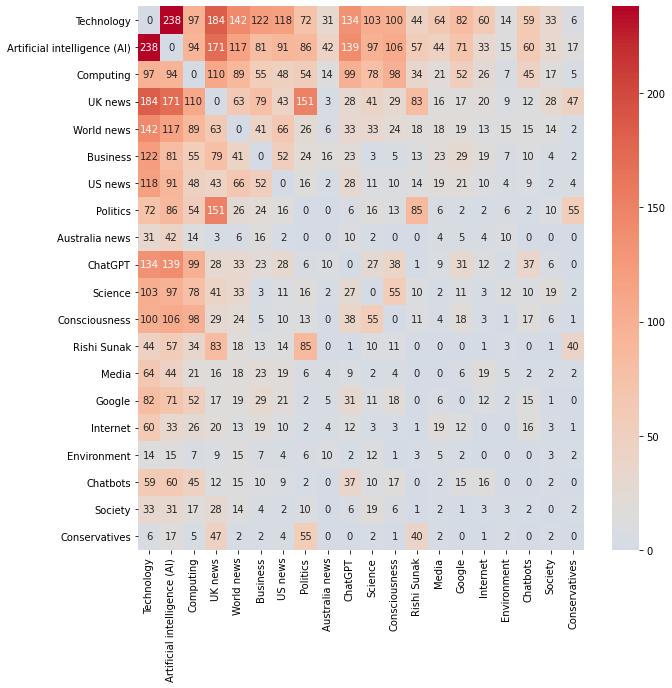

In [142]:
plt.figure(figsize=(10,10))

sns.heatmap(to_plot, cmap='coolwarm', annot=True, fmt=',', center=to_plot.melt()['value'].median())

In [78]:
pd.get_dummies(M['webTitle'])

,3D,A-levels,AT&T,Abortion,Academics,Accountancy,Acting,Activism,Adam Bandt,Adobe,...,YouTube,Young people,Youth unemployment,Yuval Noah Harari,Yvette Cooper,Zambia,Zoology,iOS,iPad,iPhone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
tag_data[['tag']]

(array([  0,   1,   2, ...,   4, 504, 484]),
 Index(['Technology', 'Artificial intelligence (AI)', 'Education', 'Computing',
        'UK news', 'Alphabet', 'Google', 'US markets', 'Business',
        'Drones (non-military)',
        ...
        'Pinterest', 'Mark Dreyfus', 'Tony Burke', 'Sally McManus',
        'Conservative leadership', 'Tom Tugendhat', 'Exhibitions', 'Pakistan',
        'Imran Khan', 'NatWest Group'],
       dtype='object', length=1131))

In [68]:
tag_data.melt(id_vars='story_index',value_vars='webTitle')

,story_index,variable,value
0,0,webTitle,Technology
1,0,webTitle,Artificial intelligence (AI)
2,0,webTitle,Education
3,1,webTitle,Artificial intelligence (AI)
4,1,webTitle,Computing
...,...,...,...
8402,1997,webTitle,Politics
8403,1997,webTitle,Business
8404,1997,webTitle,UK news
8405,1997,webTitle,Financial Conduct Authority


In [66]:
articles

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,tags,isHosted,pillarId,pillarName,byline,body,wordcount
0,technology/2023/oct/31/educators-teachers-ai-l...,article,technology,Technology,2023-10-31 10:00:39+00:00,‘Is this an appropriate use of AI or not?’: te...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Johana Bhuiyan', 'body': '<p>In <a...","[{'id': 'technology/technology', 'type': 'keyw...",False,pillar/news,News,Johana Bhuiyan,"<p>In <a href=""https://www.theguardian.com/tec...",1585
1,technology/ng-interactive/2023/oct/25/a-day-in...,interactive,technology,Technology,2023-10-25 13:38:11+00:00,A day in the life of AI,https://www.theguardian.com/technology/ng-inte...,https://content.guardianapis.com/technology/ng...,{'byline': 'Hannah Devlin Science Corresponden...,"[{'id': 'technology/artificialintelligenceai',...",False,pillar/news,News,"Hannah Devlin Science Correspondent, Rich Cous...","<figure class=""element element-atom element--i...",1741
2,technology/2023/oct/24/alphabet-q3-earnings-go...,article,technology,Technology,2023-10-24 22:07:37+00:00,Google Cloud revenue misses expectations despi...,https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,"{'byline': 'Kari Paul', 'body': '<p>Google is ...","[{'id': 'technology/alphabet', 'type': 'keywor...",False,pillar/news,News,Kari Paul,"<p>Google is doing well, but not well enough f...",554
5,technology/2023/aug/30/ai-powered-drone-beats-...,article,technology,Technology,2023-08-30 15:08:19+00:00,AI-powered drone beats human champion pilots,https://www.theguardian.com/technology/2023/au...,https://content.guardianapis.com/technology/20...,"{'byline': 'Ian Sample Science editor', 'body'...","[{'id': 'technology/technology', 'type': 'keyw...",False,pillar/news,News,Ian Sample Science editor,<p>Having trounced humans at everything from c...,690
6,technology/2023/oct/16/ai-chatbots-could-help-...,article,technology,Technology,2023-10-17 06:00:05+00:00,"AI chatbots could help plan bioweapon attacks,...",https://www.theguardian.com/technology/2023/oc...,https://content.guardianapis.com/technology/20...,{'byline': 'Dan Milmo Global technology editor...,"[{'id': 'technology/artificialintelligenceai',...",False,pillar/news,News,Dan Milmo Global technology editor,<p>The artificial intelligence models underpin...,525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,world/2022/jun/27/beyond-2022-immersive-3d-exp...,article,world,World news,2022-06-27 13:00:13+00:00,Lost Irish history reclaimed in immersive 3D ...,https://www.theguardian.com/world/2022/jun/27/...,https://content.guardianapis.com/world/2022/ju...,"{'byline': 'Caroline Davies', 'body': '<p>When...","[{'id': 'world/ireland', 'type': 'keyword', 's...",False,pillar/news,News,Caroline Davies,<p>When the Public Record Office of Ireland wa...,699
1992,world/2023/may/11/thursday-briefing-how-khans-...,article,world,World news,2023-05-11 05:47:12+00:00,Thursday briefing: How Khan’s controversial ar...,https://www.theguardian.com/world/2023/may/11/...,https://content.guardianapis.com/world/2023/ma...,"{'byline': 'Nimo Omer', 'body': '<p>Good morni...","[{'id': 'world/world', 'type': 'keyword', 'sec...",False,pillar/news,News,Nimo Omer,"<p>Good morning.</p> <p>On Tuesday, the former...",2216
1994,us-news/2023/jan/31/first-thing-biden-says-us-...,article,us-news,US news,2023-01-31 11:04:16+00:00,Biden says US ‘will not provide F-16 fighter j...,https://www.theguardian.com/us-news/2023/jan/3...,https://content.guardianapis.com/us-news/2023/...,"{'byline': 'Nicola Slawson', 'body': '<p>Good ...","[{'id': 'us-news/us-news', 'type': 'keyword', ...",False,pillar/news,News,Nicola Slawson,<p>Good morning.</p> <p>Joe Biden said the US ...,1558
1996,world/2023/jun/16/first-edition-boris-johnson-...,article,world,World news,2023-06-16 05:36:59+00:00,Friday briefing: The 1

In [59]:
top_tag_counts = tag_data['webTitle'].value_counts().head(20)
top_tag_counts


Technology                      672
Artificial intelligence (AI)    593
Computing                       377
UK news                         353
World news                      229
Business                        220
US news                         218
Politics                        179
Australia news                  154
ChatGPT                         150
Science                         136
Consciousness                   106
Rishi Sunak                     102
Media                            93
Google                           92
Internet                         70
Environment                      67
Chatbots                         65
Society                          60
Conservatives                    58
Name: webTitle, dtype: int64

In [60]:
top_tags = top_tag_counts.index
top_tags

Index(['Technology', 'Artificial intelligence (AI)', 'Computing', 'UK news',
       'World news', 'Business', 'US news', 'Politics', 'Australia news',
       'ChatGPT', 'Science', 'Consciousness', 'Rishi Sunak', 'Media', 'Google',
       'Internet', 'Environment', 'Chatbots', 'Society', 'Conservatives'],
      dtype='object')

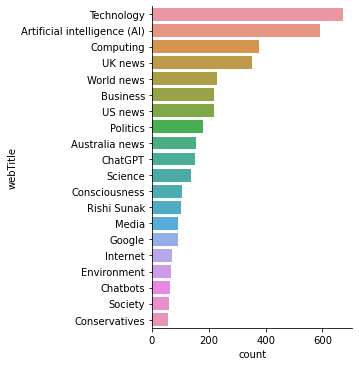

In [53]:
sns.catplot(data=tag_data, y='webTitle', kind='count', order=top_tags)

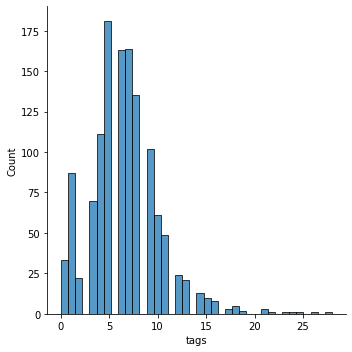

In [52]:
n_tags = articles['tags'].str.len()
sns.displot(x=n_tags, kind='hist')

,0,activeSponsorships,apiUrl,description,id,references,sectionId,sectionName,type,webTitle,webUrl
0,NaN,NaN,https://content.guardianapis.com/technology/te...,NaN,technology/technology,[],technology,Technology,keyword,Technology,https://www.theguardian.com/technology/technology
0,NaN,NaN,https://content.guardianapis.com/technology/ar...,NaN,technology/artificialintelligenceai,[],technology,Technology,keyword,Artificial intelligence (AI),https://www.theguardian.com/technology/artific...
0,NaN,NaN,https://content.guardianapis.com/education/edu...,NaN,education/education,[],education,Education,keyword,Education,https://www.theguardian.com/education/education
1,NaN,NaN,https://content.guardianapis.com/technology/ar...,NaN,technology/artificialintelligenceai,[],technology,Technology,keyword,Artificial intelligence (AI),https://www.theguardian.com/technology/artific...
1,NaN,NaN,https://content.guardianapis.com/technology/co...,NaN,technology/computing,[],technology,Technology,keyword,Computing,https://www.theguardian.com/technology/computing
...,...,...,...,...,...,...,...,...,...,...,...
1997,NaN,NaN,https://content.guardianapis.com/politics/poli...,<p><br></p>,politics/politics,[],politics,Politics,keyword,Politics,https://www.theguardian.com/politics/politics
1997,NaN,NaN,https://content.guardianapis.com/business/busi...,NaN,business/business,[],business,Business,keyword,Business,https://www.theguardian.com/business/business
1997,NaN,NaN,https://content.guardianapis.com/uk/uk,NaN,uk/uk,[],uk-news,UK news,keyword,UK news,https://www.theguardian.com/uk/uk
1997,NaN,NaN,https://content.guardianapis.com/business/fina...,The latest news and comment on the Financial C...,business/financial-conduct-authority,[],business,Business,keyword,Financial Conduct Authority,https://www.theguardian.com/business/financial...


In [22]:
articles.groupby('sectionName').agg(wc_sum=('wordcount','sum'),
                                    wc_mean=('wordcount','mean'),
                                    n_articles=('id', 'nunique')).sort_values('wc_sum', ascending=False)

,wc_sum,wc_mean,n_articles
sectionName,,,
Technology,373436,854.544622,437
Australia news,226340,2039.099099,111
Opinion,182097,905.955224,200
Politics,152909,2216.072464,69
World news,150293,1616.053763,93
Business,134205,1412.684211,94
US news,117933,1786.863636,65
Science,33949,917.540541,37
Society,29890,996.333333,30


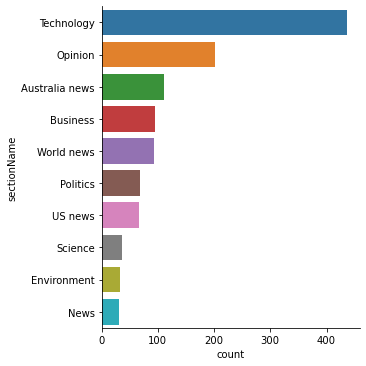

In [23]:
import seaborn as sns
section_filter = articles['sectionName'].isin(top_sections)

top_section_articles = articles[section_filter]

sns.catplot(data=top_section_articles, y='sectionName', kind='count', order=top_sections)

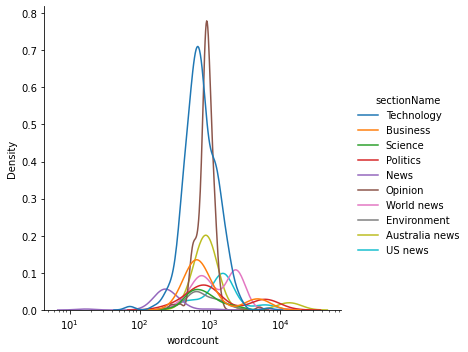

In [24]:
sns.displot(data=top_section_articles, x='wordcount', kind='kde', hue='sectionName',log_scale=True)

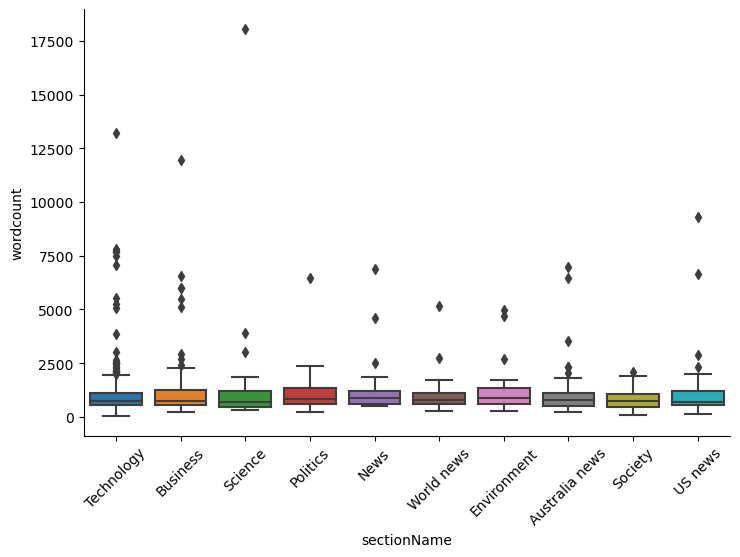

In [68]:
plot = sns.catplot(data=top_section_articles, y='wordcount', x='sectionName', aspect=1.5, kind='box')
plot.set_xticklabels(rotation=45)

In [71]:
top_section_articles = articles[section_filter]
time_grouper = pd.Grouper(key='webPublicationDate', freq='M')

date_counts = top_section_articles.groupby([time_grouper,'sectionName']).count().reset_index()
date_counts



,webPublicationDate,sectionName,id,type,sectionId,webTitle,webUrl,apiUrl,fields,tags,isHosted,pillarId,pillarName,byline,body,wordcount
0,2021-12-31 00:00:00+00:00,Business,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2022-02-28 00:00:00+00:00,Environment,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2022-03-31 00:00:00+00:00,Science,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,2022-04-30 00:00:00+00:00,Society,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2022-04-30 00:00:00+00:00,Technology,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2023-11-30 00:00:00+00:00,Politics,6,6,6,6,6,6,6,6,6,6,6,5,6,6
113,2023-11-30 00:00:00+00:00,Science,1,1,1,1,1,1,1,1,1,1,1,1,1,1
114,2023-11-30 00:00:00+00:00,Society,1,1,1,1,1,1,1,1,1,1,1,1,1,1
115,2023-11-30 00:00:00+00:00,Technology,23,23,23,23,23,23,23,23,23,23,23,23,23,23


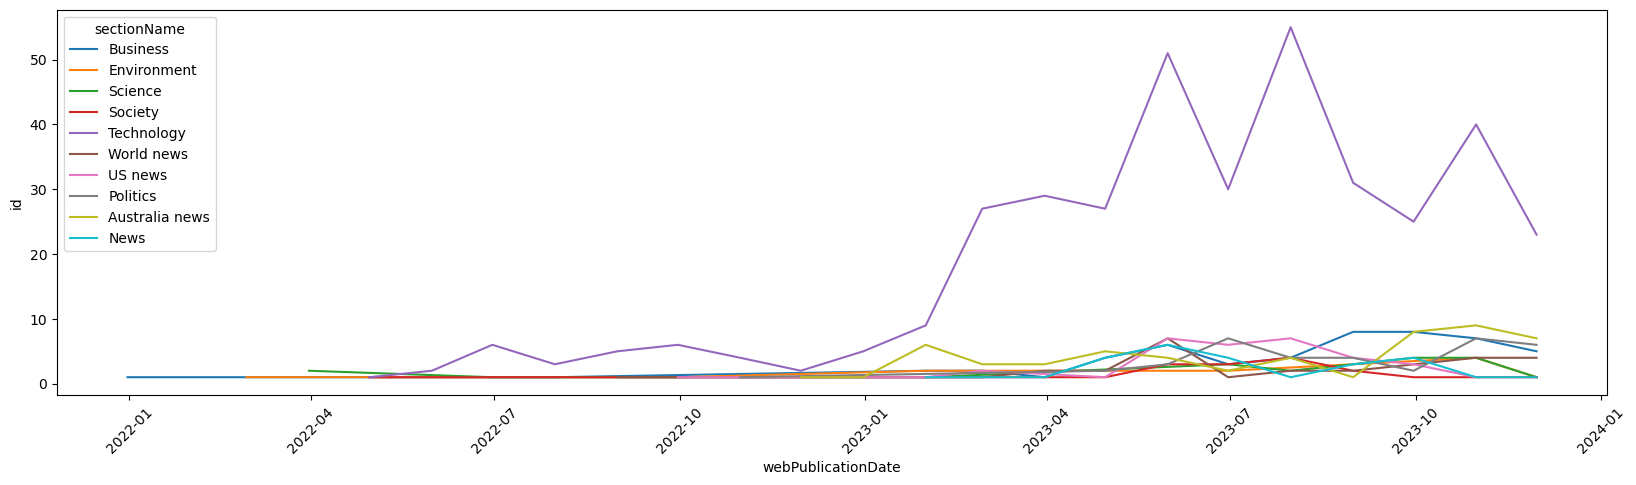

In [72]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plot = sns.lineplot(data=date_counts, x='webPublicationDate', y='id', hue='sectionName')

plot.tick_params(axis='x', labelrotation=45)

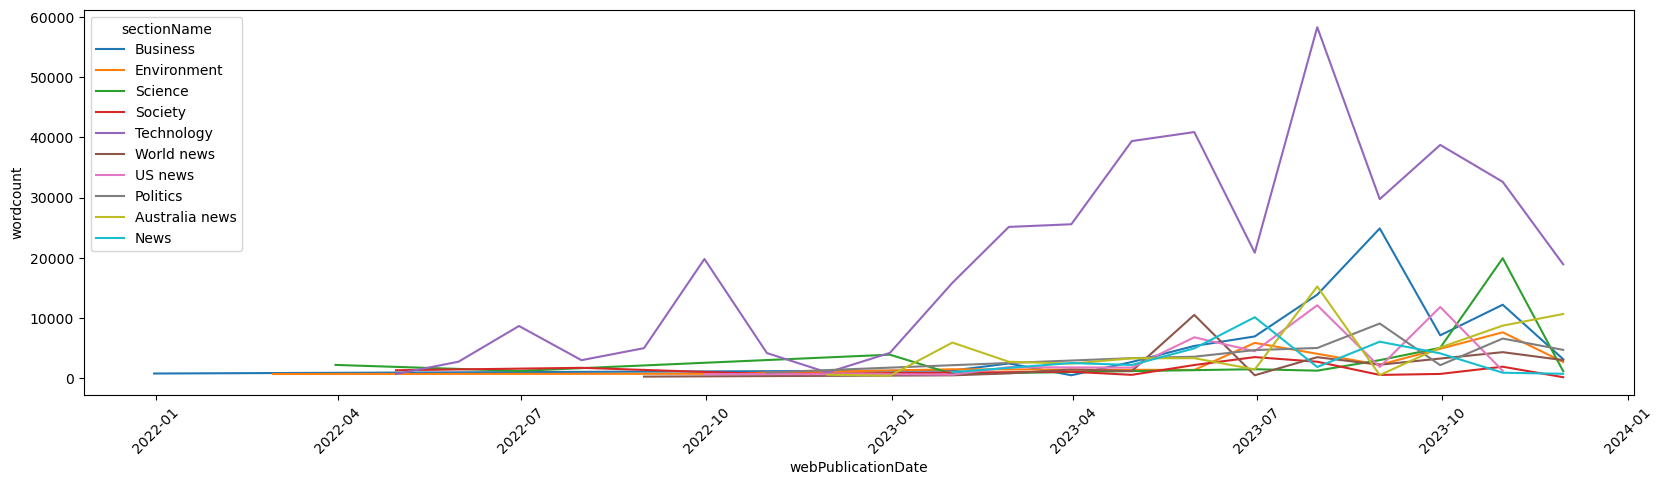

In [84]:
time_grouper = pd.Grouper(key='webPublicationDate', freq='m')
wc_per_month = top_section_articles.groupby([time_grouper,'sectionName']).sum().reset_index()
plt.figure(figsize=(20,5))
plot = sns.lineplot(data=wc_per_month, x='webPublicationDate', y='wordcount', hue='sectionName')

plot.tick_params(axis='x', labelrotation=45)

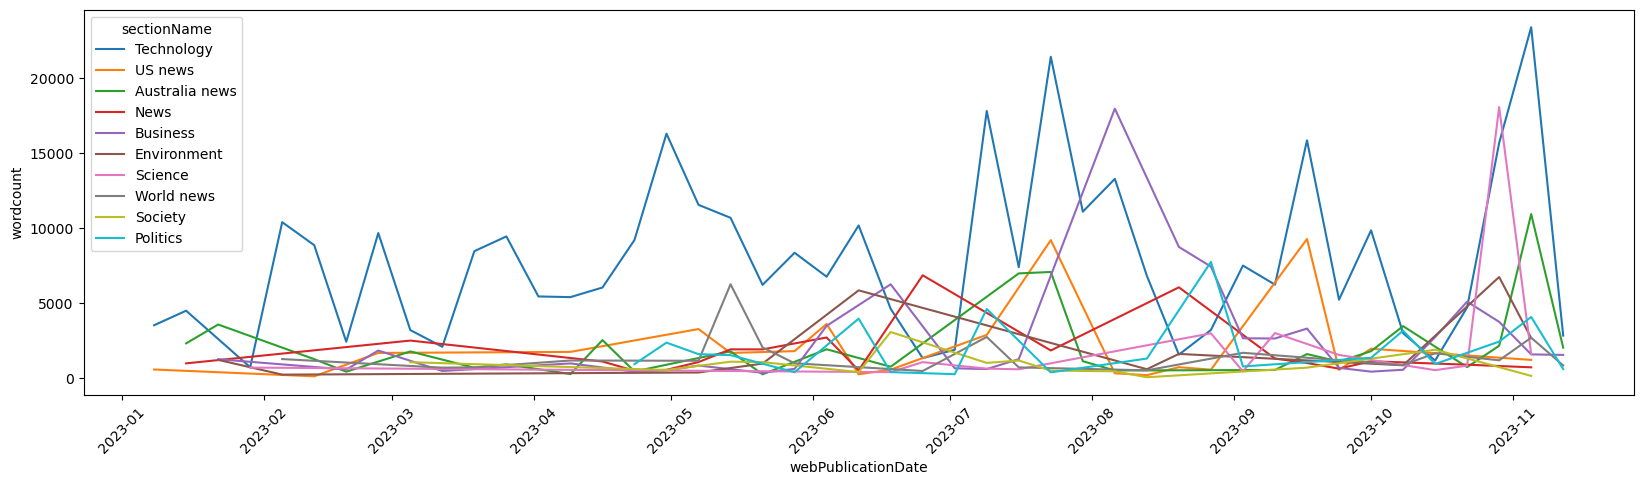

In [96]:
time_grouper = pd.Grouper(key='webPublicationDate', freq='W')  ### D, W or M

articles_2023 = top_section_articles[top_section_articles['webPublicationDate'] >= '2023']

wc_per_period = articles_2023.groupby([time_grouper,'sectionName']).sum()

plt.figure(figsize=(20,5))
plot = sns.lineplot(data=wc_per_period.reset_index(), x='webPublicationDate', y='wordcount', hue='sectionName')

plot.tick_params(axis='x', labelrotation=45)

In [98]:
wc_per_period.loc['2023-01']

isHosted  wordcount
webPublicationDate        sectionName                        
2023-01-08 00:00:00+00:00 Technology             0       3541
                          US news                0        591
2023-01-15 00:00:00+00:00 Australia news         0       2332
                          News                   0       1000
                          Technology             0       4509
2023-01-22 00:00:00+00:00 Australia news         0       3590
                          Business               0       1275
                          Environment            0       1233
2023-01-29 00:00:00+00:00 Science                0        719
                          Technology             0        741